In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
# the file 
flux = "../data/flux_lim/Flux_limite_Plio1990.grd"

In [3]:
# some geographical and infos about the raster
Qlim = Raster.load(flux)
x0,x1,y0,y1 = Qlim.bounds
values = Qlim.get_array(1)
nrow,ncol = values.shape

Lx = x1-x0
Ly = y1-y0

dx = Lx/ncol
dy = Ly/nrow

area = dx*dy # m2, will be used to normalize the values

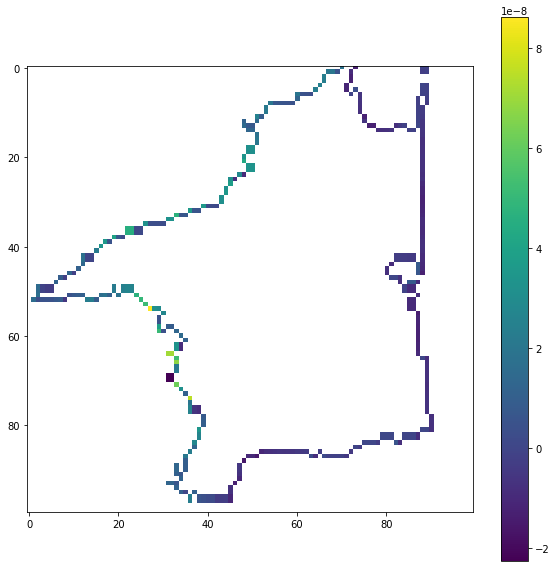

In [14]:
nrow = ncol = 100
dc = (Lx/ncol)
dr = (Ly/nrow)
delc = np.ones(nrow)*dc
delr = np.ones(ncol)*dr

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)
Qlim_resample=Qlim.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Qlim.bands[0],
                                method="nearest")
Qlim_resample[Qlim_resample==-999]=None
Qlim_resample/=area

fig = plt.figure(figsize=(10,10))
plt.imshow(Qlim_resample)
plt.colorbar()

In [6]:
def load_flux_bc(path,g):
    
    """
    resample a raster file to a new resolution given a certain grid, made to import the bc flux map
    """
    Qlim = Raster.load(path)
    x0,x1,y0,y1 = Qlim.bounds
    values = Qlim.get_array(1)
    #values[values==-999]=None
    nrow,ncol = values.shape
    Lx = x1-x0
    Ly = y1-y0
    dx = Lx/ncol
    dy = Ly/nrow
    area = dx*dy
    
    Qlim_resample=Qlim.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Qlim.bands[0],
                                method="nearest")
    
    Qlim_resample[Qlim_resample==-999]=None
    return Qlim_resample/area

In [7]:
# quick code to read all the grd files in a given folder and store the path in a list
folder_path = "../data/flux_lim"
lst_files =[]
for file in glob.glob(os.path.join(folder_path, '*.grd')):
    lst_files.append(file)

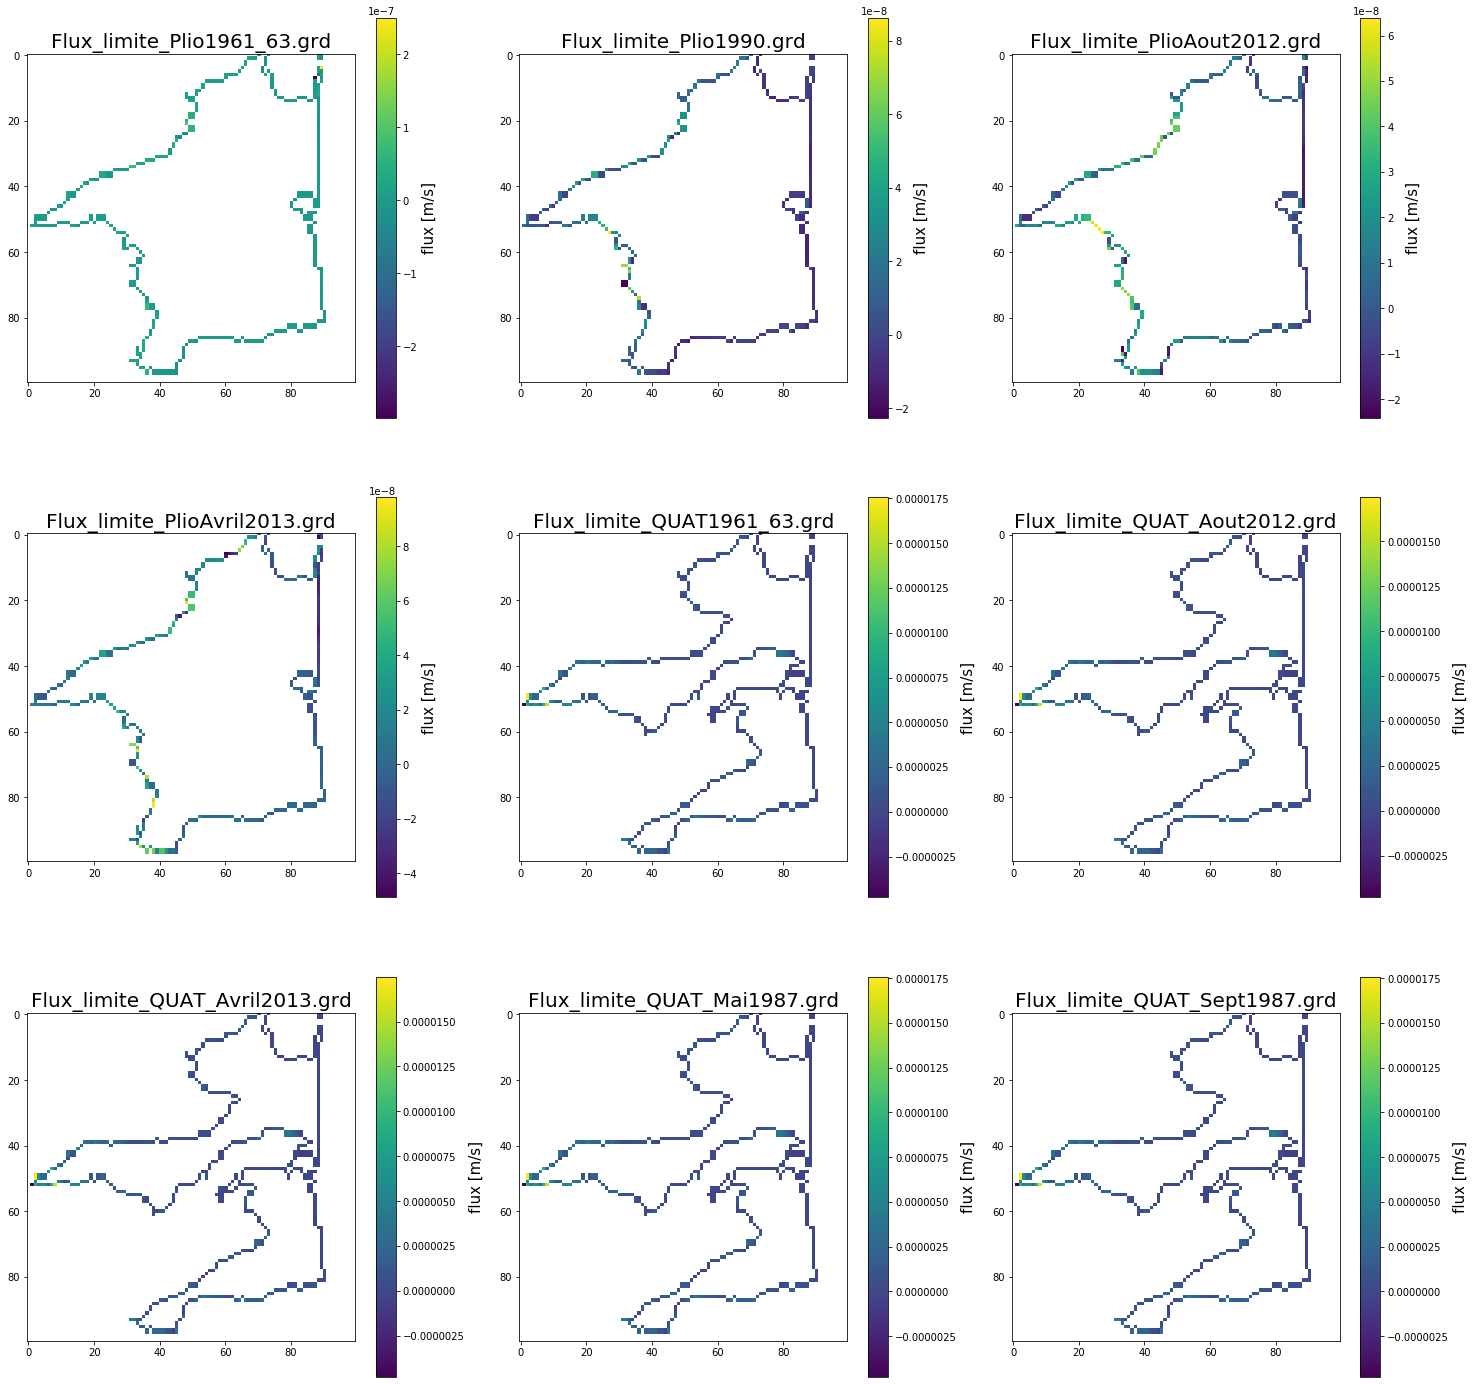

In [8]:
fig = plt.figure(figsize=(25,25))
o=0
for i in lst_files:
    o +=1
    plt.subplot(3,3,o)   
    plt.imshow(load_flux_bc(i,grid))
    plt.title(i.split(sep="\\")[-1],fontsize=20)
    g=plt.colorbar();g.set_label("flux [m/s]",fontsize=15)